In [1]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas as pd
image_df = pd.read_csv("../data/images.csv")
object_df = pd.read_csv("../data/object_location_data_clustered.csv").merge(
    image_df, how="left", on="cluster_id", suffixes=("", "_image")
)
image_df

w = 1280
h = 1280
zoom = 17

def getPointLatLng(x, y, lat, lng):
    parallelMultiplier = math.cos(lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = lat - degreesPerPixelY * ( y - h / 2)
    pointLng = lng + degreesPerPixelX * ( x  - w / 2)

    return (pointLat, pointLng)

image_size = 0.01
def get_patch(row):
    ne = getPointLatLng(w, 0, row.center_lat_image, row.center_lon_image)
    sw = getPointLatLng(0, h, row.center_lat_image, row.center_lon_image)
    nw = getPointLatLng(0, 0, row.center_lat_image, row.center_lon_image)
    se = getPointLatLng(w, h, row.center_lat_image, row.center_lon_image)
    size_lat = ne[0] - se[0]
    size_lon = ne[1] - nw[1]
    return pd.Series(dict(
        y_min = (0.5 - (row.min_lat - row.center_lat_image)/size_lat)+0.05,  # add a small buffer
        y_max = (0.5 - (row.max_lat - row.center_lat_image)/size_lat)-0.05,
        x_min = (0.5 + (row.min_lon - row.center_lon_image)/size_lon)-0.05,
        x_max = (0.5 + (row.max_lon - row.center_lon_image)/size_lon)+0.05,
    ))
patches = object_df.apply(get_patch, axis=1)
patches["cluster_id"] = object_df["cluster_id"]

In [2]:
image_patches = []
for cid in image_df.cluster_id:
    image_patches.append(patches.loc[patches["cluster_id"]==cid, ["y_min", "x_min", "y_max", "x_max"]].values)
image_patches[700]

array([[0.56311572, 0.43616462, 0.43579131, 0.56383538]])

In [3]:
def img_gen():
    for p in image_patches:
        yield p
def label_gen():
    for p in image_patches:
        yield np.ones_like(p[:, 0], dtype=np.uint8) - 1

(array([[0.20063196, 0.5657803 , 0.05422145, 0.7123836 ],
        [0.25993428, 0.5621394 , 0.11352377, 0.70874274],
        [0.6724722 , 0.39320213, 0.52735084, 0.53834915],
        [0.67376137, 0.33421972, 0.52864003, 0.47936675],
        [0.81557125, 0.38300765, 0.6704499 , 0.5281547 ],
        [0.81686044, 0.32402524, 0.6704499 , 0.46990046]], dtype=float32),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=float32))

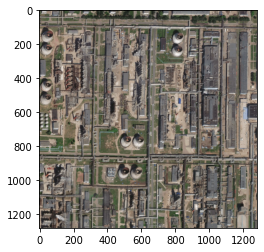

In [4]:
# Load images and visualize
train_image_dir = '../data/images'
# Make a Dataset of file names including all the PNG images files in
# the relative image directory.
filename_dataset = tf.data.Dataset.from_tensor_slices(train_image_dir + "/" + image_df.image_id + ".png")
image_ds = filename_dataset.map(lambda x: tf.io.decode_png(tf.io.read_file(x)))
bbox_ds = tf.data.Dataset.from_generator(img_gen, output_types=tf.float32).map(tf.convert_to_tensor)
class_ds = tf.data.Dataset.from_generator(label_gen, output_types=tf.uint8).map(lambda x: tf.one_hot(x, depth=1))
ds = tf.data.Dataset.zip((image_ds, bbox_ds, class_ds))
train_ds = ds.take(1000)
val_ds = ds.skip(1000).take(150)
test_ds = ds.skip(1150).take(150)
for img, boxes, cls in train_ds.take(1):
    break
plt.imshow(img)
boxes.numpy(), cls.numpy()

In [5]:
crops = tf.image.crop_and_resize(
    tf.expand_dims(img, axis=0), boxes, box_indices=[0]*len(boxes), crop_size=[100, 100], method='bilinear',
    extrapolation_value=0, name=None
).numpy()
crops.shape

(6, 100, 100, 3)

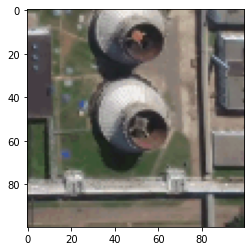

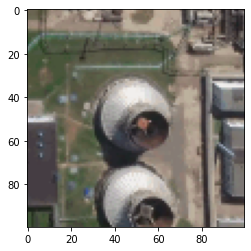

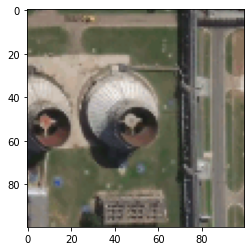

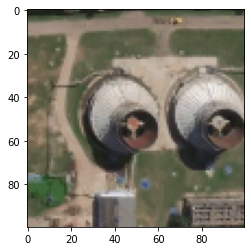

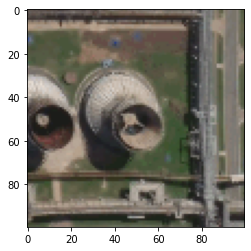

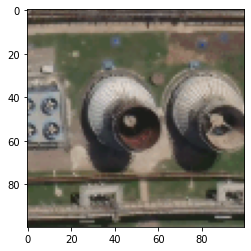

In [6]:
for i in range(crops.shape[0]):
    plt.imshow(crops[i].astype(np.uint8))
    plt.show()

In [7]:
IMAGE_SIZE = 128

def sample_positives(img, boxes, cls):
    crops = tf.image.crop_and_resize(
        tf.expand_dims(img, axis=0), boxes, box_indices=tf.zeros_like(boxes[:, 0], dtype=tf.int32),
        crop_size=[IMAGE_SIZE, IMAGE_SIZE], method='bilinear',
        extrapolation_value=0, name=None
    )
    return tf.data.Dataset.from_tensor_slices(crops)
def add_positive_label(img):
    return img, 1
def sample_negatives(img, boxes, cls):
    return tf.cast(tf.image.random_crop(img, size=[IMAGE_SIZE, IMAGE_SIZE, 3]), np.float32)
def add_negative_label(img):
    return img, 0


In [8]:
positives = ds.flat_map(sample_positives).map(add_positive_label)
negatives = ds.map(sample_negatives).map(add_negative_label)
positives, negatives

(<MapDataset shapes: ((128, 128, None), ()), types: (tf.float32, tf.int32)>,
 <MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int32)>)

In [9]:
mix = tf.data.experimental.sample_from_datasets([positives, negatives])

In [10]:
# get size of dataset
for i, _ in enumerate(mix.take(-1)):
    pass
num_samples = i+1
num_samples

4862

In [11]:
half_the_data = int(num_samples/2)
train_ds = mix.take(half_the_data).shuffle(500).batch(32)
val_ds = mix.skip(half_the_data).take(half_the_data).batch(1)

In [39]:
import os
feature_extractor_model = tf.keras.models.load_model(
    os.path.join("/home/joe/Downloads", "resisc_224px_rgb_resnet50")
)

feature_extractor_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [44]:
feature_extractor_model.layers.pop(0)
#feature_extractor_model.summary()


In [31]:
images = tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])
module = tf.keras.models.load_model(os.path.join("/home/joe/Downloads", "resisc_224px_rgb_resnet50"))
module.layers = module.layers[1:]
features = module(data_augmentation(images))
pooled_features = tf.keras.layers.GlobalAveragePooling2D()
output = tf.keras.layers.Dense(1, activation="sigmoid")(features)
model = tf.keras.Model(inputs=images, outputs=output)
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-4),
  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
  metrics=['acc']
)
model.fit(train_ds, validation_data=val_ds, epochs=3)
val_preds = model.predict(val_ds)

AttributeError: Can't set the attribute "layers", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

In [13]:
y_true = np.concatenate([cls for img, cls in val_ds.take(-1)])

In [14]:
diff = (y_true - val_preds.flatten())

In [15]:
pd.Series(diff).sort_values()

52     -0.996577
50     -0.996397
202    -0.995988
218    -0.991809
87     -0.987363
          ...   
2395    0.984731
1837    0.987505
2394    0.988788
68      0.990693
94      0.998536
Length: 2431, dtype: float64

/home/joe/PycharmProjects/osm-ai-tools/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


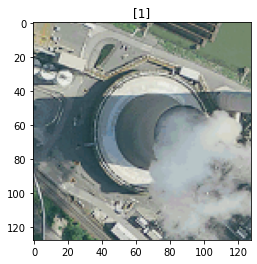

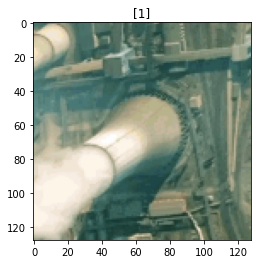

In [16]:
for img, cls in val_ds.skip(pd.Series(diff).idxmax()-1).take(1):
    plt.imshow(img.numpy()[0].astype(np.uint8))
    plt.title(cls.numpy())
plt.show()
for img, cls in val_ds.skip(pd.Series(diff).idxmax()).take(1):
    plt.imshow(img.numpy()[0].astype(np.uint8))
    plt.title(cls.numpy())
plt.show()


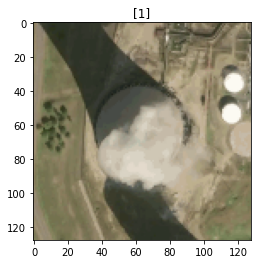

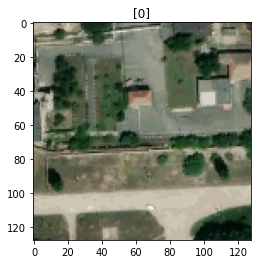

In [17]:
for img, cls in val_ds.skip(pd.Series(diff).idxmin()-1).take(1):
    plt.imshow(img.numpy()[0].astype(np.uint8))
    plt.title(cls.numpy())
plt.show()

for img, cls in val_ds.skip(pd.Series(diff).idxmin()).take(1):
    plt.imshow(img.numpy()[0].astype(np.uint8))
    plt.title(cls.numpy())
plt.show()


In [18]:
for img in image_ds.skip(1000).take(1):
    break

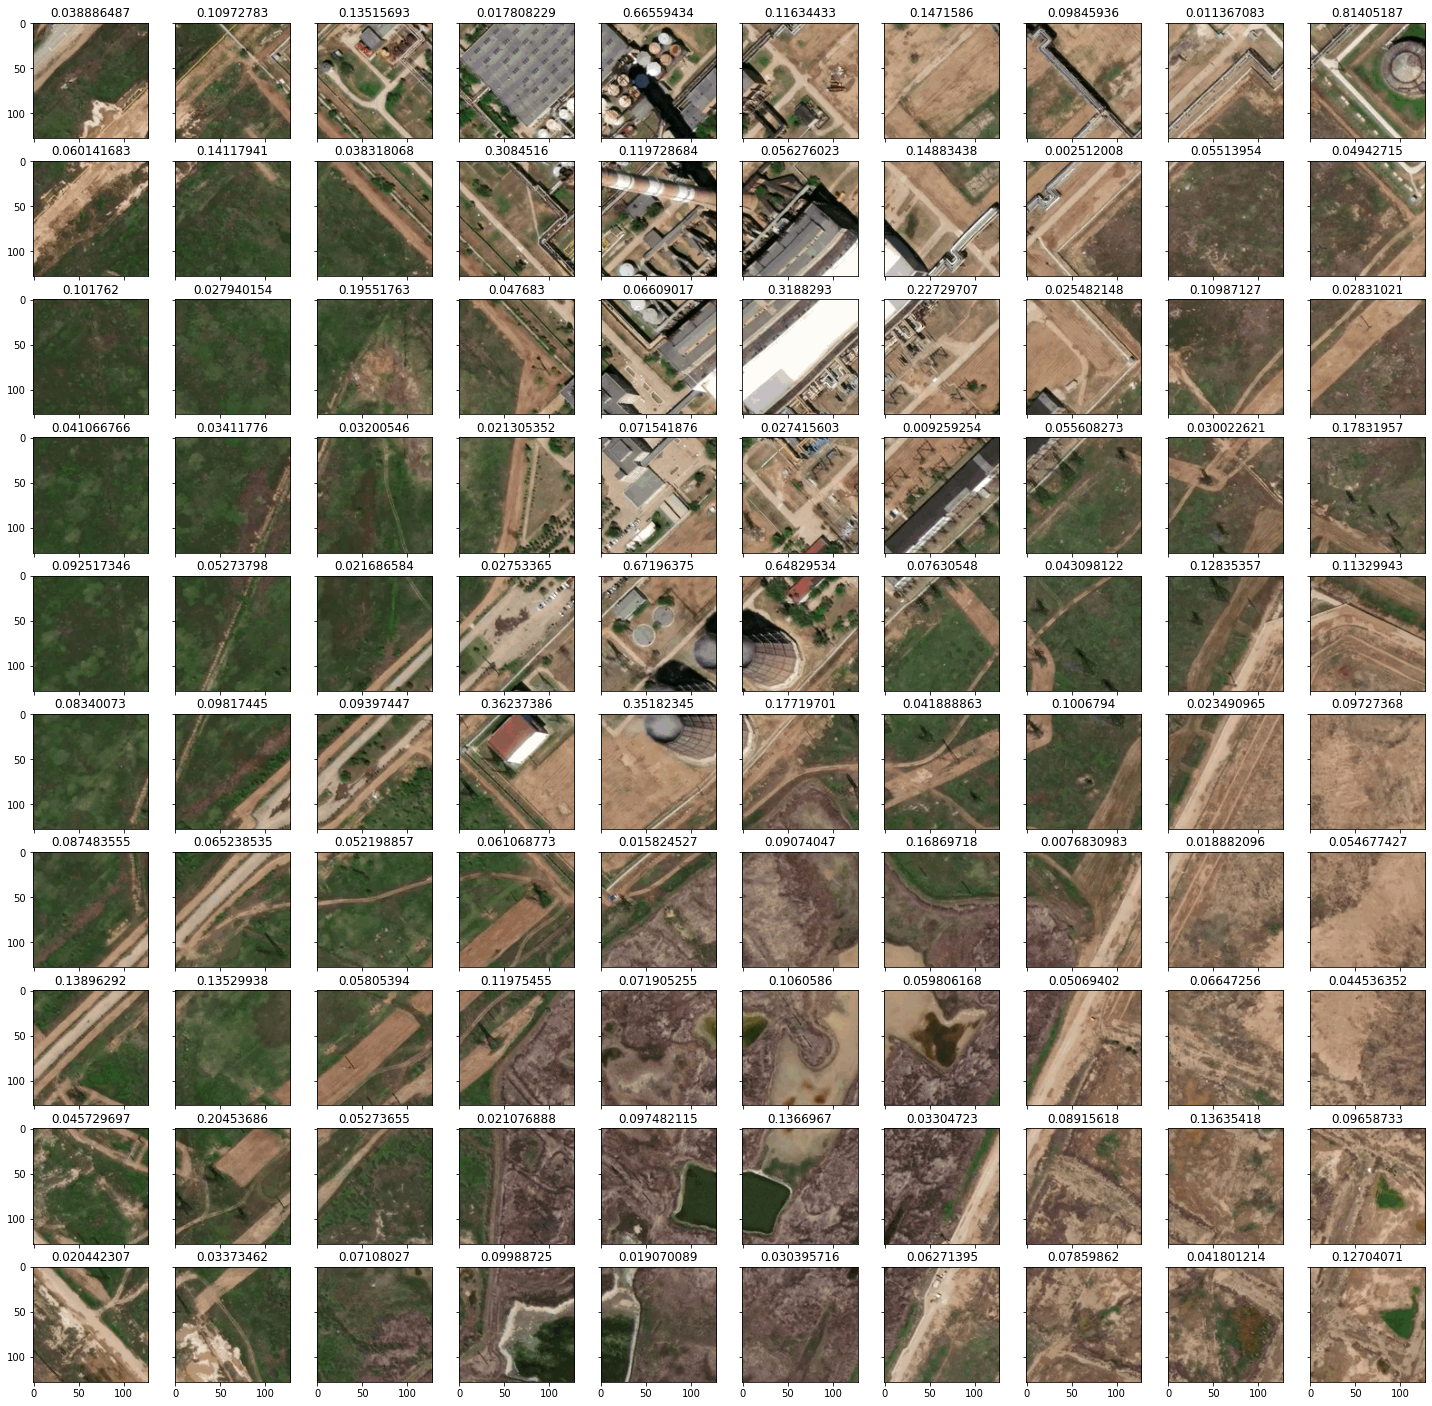

In [19]:
images = []
i=0
f, ax = plt.subplots(10,10,figsize=(25,25), sharex=True, sharey=True)
for i, x in enumerate(range(0, 1280, IMAGE_SIZE)):
    for j, y in enumerate(range(0, 1280, IMAGE_SIZE)):
        image = img[x:x+IMAGE_SIZE, y:y+IMAGE_SIZE, :]
        ax[i][j].imshow(image.numpy().astype(np.uint8))
        ax[i][j].set_title(model.predict(tf.expand_dims(image, axis=0))[0][0])
plt.show()


In [20]:
import tensorflow_hub as hub
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/4"

images = tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])
module = hub.KerasLayer(feature_extractor_model, trainable=True)
features = module(data_augmentation(images))
features = tf.keras.layers.Dropout(0.5)(features)
output = tf.keras.layers.Dense(1, activation="sigmoid")(features)
model = tf.keras.Model(inputs=images, outputs=output)
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),
  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
  metrics=['acc']
)
model.fit(train_ds, validation_data=val_ds, epochs=2)
val_preds = model.predict(val_ds)

Epoch 1/2
76/76 [==============================] - 172s 2s/step - loss: 0.8976 - acc: 0.5543 - val_loss: 0.8042 - val_acc: 0.6211
Epoch 2/2
76/76 [==============================] - 173s 2s/step - loss: 0.6277 - acc: 0.7464 - val_loss: 0.6898 - val_acc: 0.7232
